# Overview
The project involves contributors evaluating tweets related to various brands and products. The crowd is tasked with determining whether each tweet expresses positive, negative, or neutral emotions towards a brand and/or product mentioned. Additionally, if there is emotional content, contributors are asked to identify which specific brand or product is being targeted.

# Business Understanding
Understanding public sentiment towards brands and products is crucial for businesses to gauge their reputation, assess customer satisfaction, and identify areas for improvement. Analyzing social media data like tweets provides valuable insights into consumer opinions and preferences.

# Data Understanding
The dataset contains 9093 rows of tweets related to multiple brands and products. Each tweet is annotated by contributors to indicate the sentiment expressed (positive, negative, or neutral) and specify the brand or product targeted by the emotion.

# Main Objective
The main objective of the project is to analyze the sentiment of tweets towards various brands and products. By categorizing the sentiment as positive, negative, or neutral and identifying the specific targets of emotions, the aim is to gain insights into consumer perceptions and attitudes.

## Specific Objectives:

1.Classify each tweet as expressing positive, negative, or neutral sentiment towards brands and products.

2.Identify the specific brands or products targeted by the emotional content in each tweet.

3.Analyze the overall sentiment distribution across brands and products.

4.Explore patterns and trends in consumer sentiment over time or in response to specific events or marketing campaigns.


## Import Relevant Libraries

In [194]:
#import libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
# from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Dataset

In [195]:
# load the dataset
data = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')

data.head(5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [196]:
# Rename the columns
data.rename(columns={
    'tweet_text': 'tweet',
    'emotion_in_tweet_is_directed_at': 'product',
    'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'
}, inplace=True)

# Check the updated df
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## EXPLORE THE DATASET

In [197]:
# explore the data
print('The dataset has {} rows and {} columns'.format(data.shape[0], data.shape[1]))
print('\nFeatures:')
print(data.columns.values)
print('\nFirst 5 rows:')
print(data.head())
print('\nInfo:')
print(data.info())


The dataset has 9093 rows and 3 columns

Features:
['tweet' 'product' 'sentiment']

First 5 rows:
                                               tweet             product  \
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

          sentiment  
0  Negative emotion  
1  Positive emotion  
2  Positive emotion  
3  Negative emotion  
4  Positive emotion  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9092 non-null   object
 1   product    3291 non-null   object
 2   sentiment  9093 non-null   object
dtype

## Distribution of the Sentiments


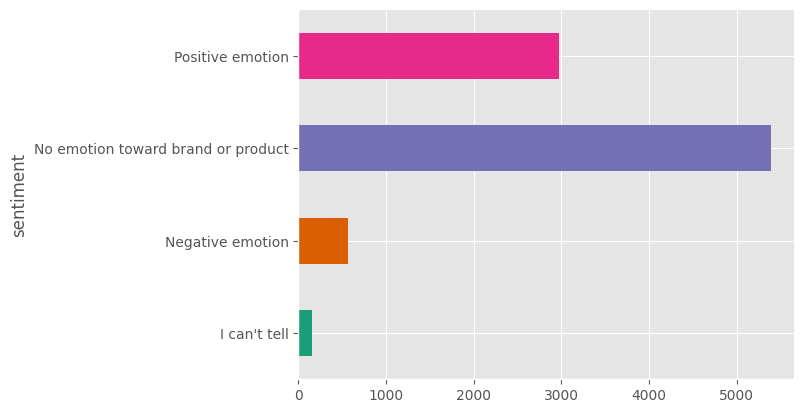

In [198]:
# distribution of the sentiment libraries
data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

## Missing Values

In [199]:
# Explore the data
# Data types of columns
data_types = data.dtypes
print("Data types of columns:")
print(data_types)

# Missing values
missing_values = data.isnull().sum()
print("\nMissing values:")
print(missing_values)

Data types of columns:
tweet        object
product      object
sentiment    object
dtype: object

Missing values:
tweet           1
product      5802
sentiment       0
dtype: int64


In [200]:
# Function to extract related words to Apple and Google Products
def extract_product(tweet):
    # Dictionary mapping keywords to products
    tweet_lower = str(tweet).lower()
    product_keywords = {
        'Apple': ['apple', 'iphone', 'ipad', 'macbook', 'apple watch',
                  'airpods', 'ios', 'macos', 'app store', 'icloud', 'itunes'],
        'Google': ['google', 'pixel', 'pixelbook', 'chromebook', 'google home',
                   'nest', 'android', 'google play store',
                   'google maps', 'gmail', 'goog']
    }

    # Check if tweet is a valid string
    if isinstance(tweet, str):
        # Iterate through the dictionary to find a match
        for product, keywords in product_keywords.items():
            if any(keyword in tweet_lower for keyword in keywords):
                return product
    return None

# Replace NaN values in 'product' column with appropriate match
data['product'] = data.apply(lambda row: extract_product(row['tweet']) if pd.isna(row['product']) else row['product'], axis=1)


## Check Missing Values in the entire Dataset

In [201]:
# Check for missing values
missing_values = data.isnull().sum()

print("Missing values per column:")
print(missing_values)


Missing values per column:
tweet          1
product      703
sentiment      0
dtype: int64


## Drop Missing Values in Tweet and Product Column

In [202]:
#Drop missing values in tweet and product column
data.dropna(subset=['tweet','product'], inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8390 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      8390 non-null   object
 1   product    8390 non-null   object
 2   sentiment  8390 non-null   object
dtypes: object(3)
memory usage: 262.2+ KB


In [203]:
# prompt: drop the rows in the sentiment that have "I can't tell' words

data = data[data['sentiment'] != "I can't tell"]

# Replace 'No emotion toward brand or product' with 'Neutral'
data['sentiment'] = data['sentiment'].replace('No emotion toward brand or product', 'Neutral')

# Print unique sentiment values after changes
print("Unique sentiment values after changes:", data['sentiment'].unique())



Unique sentiment values after changes: ['Negative emotion' 'Positive emotion' 'Neutral']


## Data Pre-processing

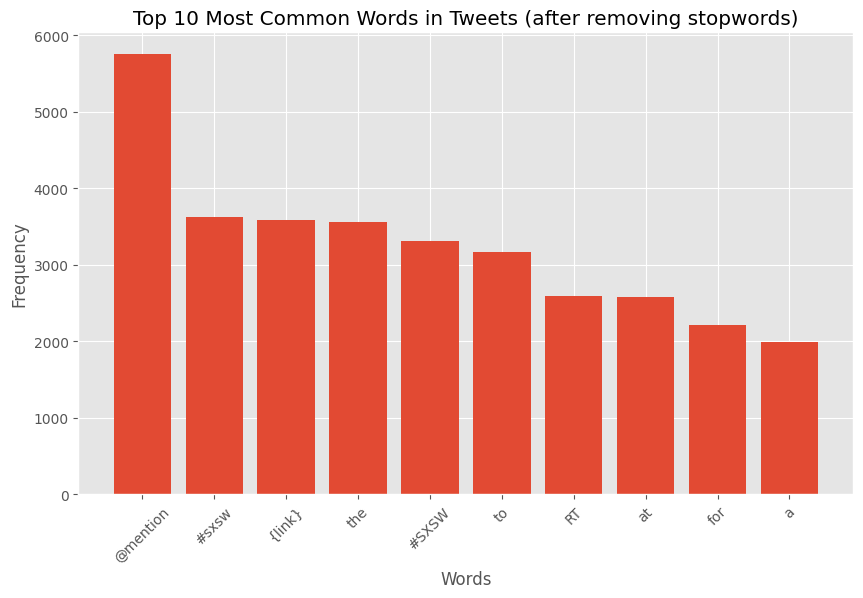

In [204]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenization
tokenized_tweets = [word for tweet in data['tweet'] for word in tweet.split()]

# Counting
word_counts = Counter(tokenized_tweets)

# Filtering (optional)
# Remove stopwords, punctuation, or other irrelevant tokens if not already done during preprocessing

# Sorting
most_common_words = word_counts.most_common()

# Visualization
top_n = 10  # Choose the number of top words to display
top_words, top_counts = zip(*most_common_words[:top_n])

plt.figure(figsize=(10, 6))
plt.bar(top_words, top_counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words in Tweets (after removing stopwords)')
plt.xticks(rotation=45)
plt.show()


In [205]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocess the text data
def preprocess_text(text):
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    return text
stopwords_list = stopwords.words('english')
import string
stopwords_list += string.punctuation
common_words = ['sxsw','mention','link','sxtxstate']
for words in common_words:
    stopwords_list.append(words)
st = nltk.PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [st.stem(word) for word in stemmed_content if word not in stopwords_list]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content



# Apply preprocessing to the 'tweet' column
data['tweet'] = data['tweet'].apply(preprocess_text)

# Tokenize the text data
nltk.download('punkt')
data['tokenized_tweet'] = data['tweet'].apply(word_tokenize)

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
data['filtered_tweet'] = data['tokenized_tweet'].apply(lambda tokens: [token for token in tokens if token not in stopwords_list])
data['tweet'] = data['tweet'].apply(stemming)

# Convert tokenized text into numerical representation using Bag-of-Words
count_vectorizer = CountVectorizer()
bow_representation = count_vectorizer.fit_transform(data['filtered_tweet'].apply(lambda tokens: ' '.join(tokens)))

# Convert tokenized text into numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf_representation = tfidf_vectorizer.fit_transform(data['filtered_tweet'].apply(lambda tokens: ' '.join(tokens)))

# Print the first few rows of the preprocessed data
data.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ronal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,tweet,product,sentiment,tokenized_tweet,filtered_tweet
0,wesley g iphon hr tweet riseaustin dead need u...,iPhone,Negative emotion,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, riseaustin,..."
1,jessede know fludapp awesom ipadiphon app youl...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipadiphone,..."
2,swonderlin wait ipad also sale,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale]"
3,hope year festiv isnt crashi year iphon app,iPad or iPhone App,Negative emotion,"[sxsw, i, hope, this, years, festival, isnt, a...","[hope, years, festival, isnt, crashy, years, i..."
4,great stuff fri marissa mayer googl tim oreill...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[great, stuff, fri, marissa, mayer, google, ti..."


In [206]:
print(tfidf_representation)

  (0, 7954)	0.3715035507867214
  (0, 6134)	0.3502243513301513
  (0, 8980)	0.30733402648499014
  (0, 5402)	0.2007167673370108
  (0, 2003)	0.3257392254898428
  (0, 7115)	0.3715035507867214
  (0, 8840)	0.2815470295642019
  (0, 3883)	0.34262947630479773
  (0, 4225)	0.1138078498204046
  (0, 9286)	0.38839380160167636
  (1, 8788)	0.32838379695751563
  (1, 3123)	0.1679764982412299
  (1, 3346)	0.2200278021700414
  (1, 8509)	0.2407730678208936
  (1, 216)	0.21736595789081403
  (1, 2096)	0.1977245115542674
  (1, 393)	0.31295631335706153
  (1, 4692)	0.28353732246925173
  (1, 9560)	0.24926342472116894
  (1, 348)	0.1306921836385146
  (1, 4204)	0.2935199826451247
  (1, 594)	0.2009237779915033
  (1, 3027)	0.35475725436963107
  (1, 4496)	0.1882647046007691
  (1, 4338)	0.35475725436963107
  :	:
  (8237, 9463)	0.2662888407060977
  (8237, 6991)	0.25769899410908526
  (8237, 6955)	0.2662888407060977
  (8237, 5435)	0.1965573065079014
  (8237, 6224)	0.23033963605808064
  (8237, 9548)	0.178899862036244
  (8237,

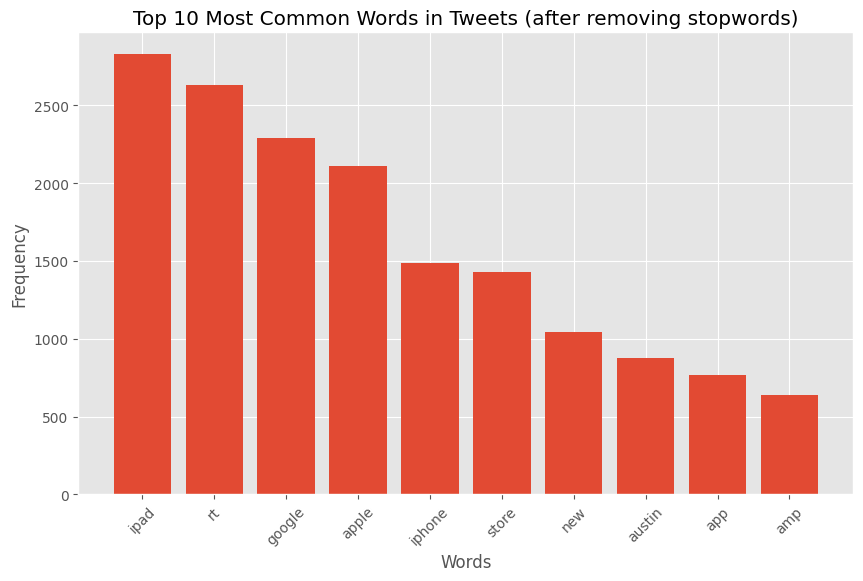

In [207]:
from collections import Counter
import matplotlib.pyplot as plt

# Tokenization
tokenized_tweets = [word for tweet in data['filtered_tweet'] for word in tweet]

# Counting
word_counts = Counter(tokenized_tweets)

# Filtering (optional)
# Remove stopwords, punctuation, or other irrelevant tokens if not already done during preprocessing

# Sorting
most_common_words = word_counts.most_common()

# Visualization
top_n = 10  # Choose the number of top words to display
top_words, top_counts = zip(*most_common_words[:top_n])

plt.figure(figsize=(10, 6))
plt.bar(top_words, top_counts)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title(f'Top {top_n} Most Common Words in Tweets (after removing stopwords)')
plt.xticks(rotation=45)
plt.show()


In [208]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# text = ''

# wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tokenized_tweets)

# # Display the word cloud
# plt.figure(figsize=(10, 5))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()


In [209]:
from textblob import TextBlob

# Function for sentiment analysis
def analyze_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Apply sentiment analysis to the preprocessed tweets
data['sentiment_score'] = data['tweet'].apply(analyze_sentiment)

# Categorize sentiment into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

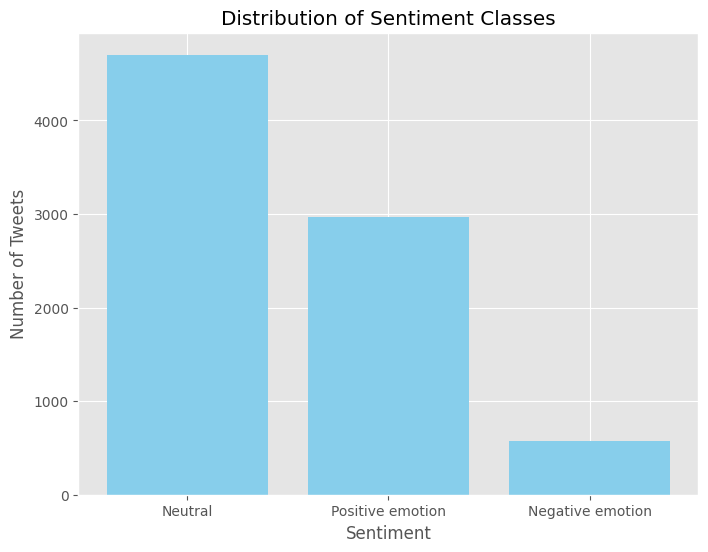

In [210]:
import matplotlib.pyplot as plt
# Count the number of tweets in each sentiment class
sentiment_counts = data['sentiment'].value_counts()

# Create a bar chart of the sentiment distribution
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')

# Set the chart title and labels
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# Display the chart
plt.show()


## Check Class Imbalance in the Dataset

In [211]:

# Calculate the proportion of each sentiment class
sentiment_proportions = data['sentiment'].value_counts(normalize=True)

# Print the sentiment proportions
print(sentiment_proportions)

# Check for class imbalance by comparing the proportions
if sentiment_proportions.max() / sentiment_proportions.min() > 2:
  print('There is class imbalance in the dataset.')
else:
  print('The dataset is balanced.')


sentiment
Neutral             0.570752
Positive emotion    0.360194
Negative emotion    0.069053
Name: proportion, dtype: float64
There is class imbalance in the dataset.


In [212]:
integer_tweet = {'Positive emotion':1,'Negative emotion':0,'Neutral':2}
data['sentiment'] = data['sentiment'].replace(integer_tweet)
data.head()

,tweet,product,sentiment,tokenized_tweet,filtered_tweet,sentiment_score
0,wesley g iphon hr tweet riseaustin dead need u...,iPhone,0,"[wesley, i, have, a, g, iphone, after, hrs, tw...","[wesley, g, iphone, hrs, tweeting, riseaustin,...",-0.2
1,jessede know fludapp awesom ipadiphon app youl...,iPad or iPhone App,1,"[jessedee, know, about, fludapp, awesome, ipad...","[jessedee, know, fludapp, awesome, ipadiphone,...",0.4
2,swonderlin wait ipad also sale,iPad,1,"[swonderlin, can, not, wait, for, ipad, also, ...","[swonderlin, wait, ipad, also, sale]",0.0
3,hope year festiv isnt crashi year iphon app,iPad or iPhone App,0,"[sxsw, i, hope, this, years, festival, isnt, a...","[hope, years, festival, isnt, crashy, years, i...",0.0
4,great stuff fri marissa mayer googl tim oreill...,Google,1,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[great, stuff, fri, marissa, mayer, google, ti...",0.8


In [213]:

import pandas as pd
# Handle class imbalance using oversampling
from imblearn.over_sampling import SMOTE

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(bow_representation, data['sentiment'], test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the class distribution after oversampling
print(pd.Series(y_train_resampled).value_counts())


sentiment
2    3791
1    3791
0    3791
Name: count, dtype: int64


In [214]:
print(bow_representation)

  (0, 9286)	1
  (0, 4225)	1
  (0, 3883)	1
  (0, 8840)	1
  (0, 7115)	1
  (0, 2003)	1
  (0, 5402)	1
  (0, 8980)	1
  (0, 6134)	1
  (0, 7954)	1
  (1, 4338)	1
  (1, 4496)	1
  (1, 3027)	1
  (1, 594)	1
  (1, 4204)	1
  (1, 348)	1
  (1, 9560)	1
  (1, 4692)	1
  (1, 393)	1
  (1, 2096)	1
  (1, 216)	1
  (1, 8509)	1
  (1, 3346)	1
  (1, 3123)	1
  (1, 8788)	1
  :	:
  (8237, 9589)	1
  (8237, 6030)	1
  (8237, 116)	1
  (8237, 6730)	1
  (8237, 6029)	1
  (8237, 2874)	1
  (8237, 5701)	1
  (8238, 4225)	1
  (8238, 5437)	1
  (8238, 8578)	1
  (8238, 9271)	1
  (8238, 3864)	1
  (8238, 1791)	1
  (8238, 609)	1
  (8238, 9069)	1
  (8238, 1928)	1
  (8238, 2901)	1
  (8238, 504)	1
  (8238, 1590)	1
  (8238, 9556)	1
  (8239, 3402)	1
  (8239, 7179)	1
  (8239, 1333)	1
  (8239, 5627)	1
  (8239, 8454)	1


## Modelling

### Split the Data Features to train the Model

In [215]:
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and target variable (y)
X = data['filtered_tweet']
y = data['sentiment']

# Split the dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the training, validation, and testing sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (5768,) (5768,)
Validation set shape: (1236,) (1236,)
Testing set shape: (1236,) (1236,)


# Binary Classification Models

## Base Line Model
### Logistic Regression Model




In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
# Filter the dataset to include only positive and negative sentiment
filtered_data = data[data['sentiment'].isin([1, 0])]

# Split the filtered dataset into features (X) and target variable (y)
X_filtered = filtered_data['tweet']
y_filtered = filtered_data['sentiment']

# Split the filtered dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Initialize the CountVectorizer
count_vectorizer_filtered = CountVectorizer()

# Fit and transform the training data
X_train_bow_filtered = count_vectorizer_filtered.fit_transform(X_train_filtered)

# Transform the validation and testing data
X_val_bow_filtered = count_vectorizer_filtered.transform(X_val_filtered)
X_test_bow_filtered = count_vectorizer_filtered.transform(X_test_filtered)

# Initialize the Logistic Regression model
clf_filtered = LogisticRegression(max_iter=1000)

# Train the model on the training data
clf_filtered.fit(X_train_bow_filtered, y_train_filtered)

# Predict on the validation data
y_val_pred_filtered = clf_filtered.predict(X_val_bow_filtered)

# Calculate accuracy on the validation set
accuracy_val_filtered = accuracy_score(y_val_filtered, y_val_pred_filtered)
print("Validation Accuracy:", accuracy_val_filtered)

# Print classification report for validation set
print("Validation Classification Report:")
print(classification_report(y_val_filtered, y_val_pred_filtered))


Validation Accuracy: 0.8775894538606404
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.37      0.49        84
           1       0.89      0.97      0.93       447

    accuracy                           0.88       531
   macro avg       0.81      0.67      0.71       531
weighted avg       0.86      0.88      0.86       531



## SVM , Naive Bayes Classification, Random Forest Models

In [217]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Split the filtered dataset into features (X) and target variable (y)
X_filtered = filtered_data['tweet']
y_filtered = filtered_data['sentiment']

# Split the filtered dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Initialize CountVectorizer
count_vectorizer_filtered = CountVectorizer()

# Fit and transform the training data
X_train_bow_filtered = count_vectorizer_filtered.fit_transform(X_train_filtered)
X_val_bow_filtered = count_vectorizer_filtered.transform(X_val_filtered)
X_test_bow_filtered = count_vectorizer_filtered.transform(X_test_filtered)

# Initialize classifiers
classifiers = {
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name}:")
    clf.fit(X_train_bow_filtered, y_train_filtered)
    y_val_pred_filtered = clf.predict(X_val_bow_filtered)

    # Calculate evaluation metrics on the validation set
    accuracy_val_filtered = accuracy_score(y_val_filtered, y_val_pred_filtered)
    precision_val_filtered = precision_score(y_val_filtered, y_val_pred_filtered, average='weighted')
    recall_val_filtered = recall_score(y_val_filtered, y_val_pred_filtered, average='weighted')
    f1_val_filtered = f1_score(y_val_filtered, y_val_pred_filtered, average='weighted')

    # Print evaluation metrics
    print("Validation Accuracy:", accuracy_val_filtered)
    print("Validation Precision:", precision_val_filtered)
    print("Validation Recall:", recall_val_filtered)
    print("Validation F1-score:", f1_val_filtered)

    # Print classification report for validation set
    print("Validation Classification Report:")
    print(classification_report(y_val_filtered, y_val_pred_filtered))



SVM:


Validation Accuracy: 0.8681732580037664
Validation Precision: 0.8860221398988077
Validation Recall: 0.8681732580037664
Validation F1-score: 0.8258785193520408
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29        84
           1       0.86      1.00      0.93       447

    accuracy                           0.87       531
   macro avg       0.93      0.58      0.61       531
weighted avg       0.89      0.87      0.83       531


Naive Bayes:
Validation Accuracy: 0.8832391713747646
Validation Precision: 0.881452913382275
Validation Recall: 0.8832391713747646
Validation F1-score: 0.8589107575489536
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.31      0.46        84
           1       0.88      0.99      0.93       447

    accuracy                           0.88       531
   macro avg       0.88      0.65      0.70       531
we

In [218]:
# prompt: fine tune the parameter to check whether the model perfomance will improve

# Initialize CountVectorizer
count_vectorizer = CountVectorizer(max_features=5000)

# Fit and transform the training data
X_train_bow = count_vectorizer.fit_transform(X_train_filtered)
X_test_bow = count_vectorizer.transform(X_test_filtered)

# Initialize SVM classifier with tuned parameters
clf_svm = SVC(C=1.0, kernel='rbf', gamma='scale')

# Train the model
clf_svm.fit(X_train_bow, y_train_filtered)

# Predict on the testing data
y_pred_svm = clf_svm.predict(X_test_bow)

# Calculate accuracy
accuracy_svm = accuracy_score(y_test_filtered, y_pred_svm)
print("SVM Accuracy:", accuracy_svm)

# Print classification report
print("SVM Classification Report:")
print(classification_report(y_test_filtered, y_pred_svm))

# Initialize Naive Bayes classifier with tuned parameters
clf_nb = MultinomialNB(alpha=0.1)

# Train the model
clf_nb.fit(X_train_bow, y_train_filtered)

# Predict on the testing data
y_pred_nb = clf_nb.predict(X_test_bow)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test_filtered, y_pred_nb)
print("Naive Bayes Accuracy:", accuracy_nb)

# Print classification report
print("Naive Bayes Classification Report:")
print(classification_report(y_test_filtered, y_pred_nb))

# Initialize Random Forest classifier with tuned parameters
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)

# Train the model
clf_rf.fit(X_train_bow, y_train_filtered)

# Predict on the testing data
y_pred_rf = clf_rf.predict(X_test_bow)

# Calculate accuracy
accuracy_rf = accuracy_score(y_test_filtered, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

# Print classification report
print("Random Forest Classification Report:")
print(classification_report(y_test_filtered, y_pred_rf))


SVM Accuracy: 0.8662900188323918
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.18      0.30        84
           1       0.87      1.00      0.93       447

    accuracy                           0.87       531
   macro avg       0.87      0.59      0.61       531
weighted avg       0.87      0.87      0.83       531

Naive Bayes Accuracy: 0.871939736346516
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.51      0.56        84
           1       0.91      0.94      0.93       447

    accuracy                           0.87       531
   macro avg       0.76      0.73      0.74       531
weighted avg       0.86      0.87      0.87       531

Random Forest Accuracy: 0.8493408662900188
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.05      0.09        84
           1       0.8

### Multiclass Classification


SVM:
Validation Accuracy: 0.8681732580037664
Validation Precision: 0.8860221398988077
Validation Recall: 0.8681732580037664
Validation F1-score: 0.8258785193520408
Validation AUC: 0.8631751358261426


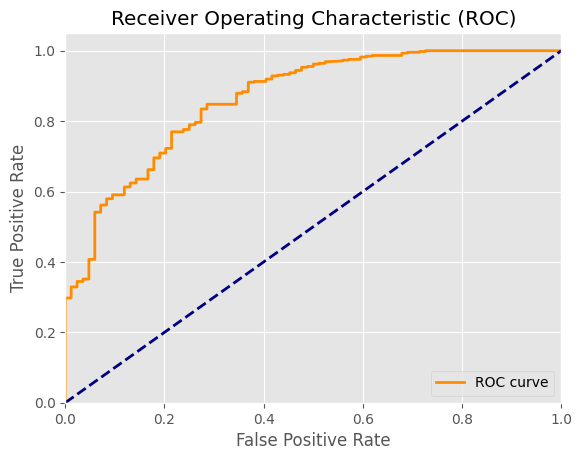


Naive Bayes:
Validation Accuracy: 0.8832391713747646
Validation Precision: 0.881452913382275
Validation Recall: 0.8832391713747646
Validation F1-score: 0.8589107575489536
Validation AUC: 0.8341589432193459


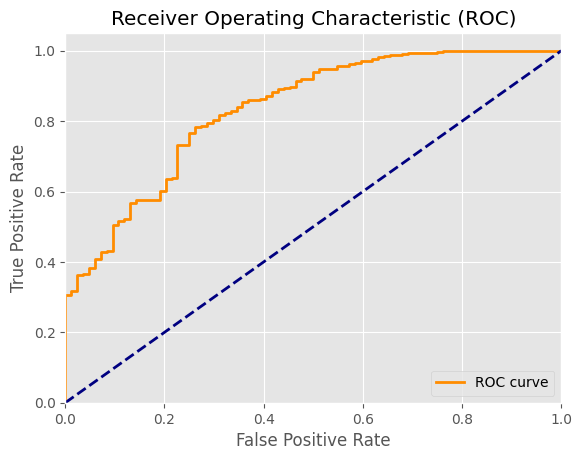


Random Forest:
Validation Accuracy: 0.8945386064030132
Validation Precision: 0.9023128883475986
Validation Recall: 0.8945386064030132
Validation F1-score: 0.8725645552055065
Validation AUC: 0.8928571428571429


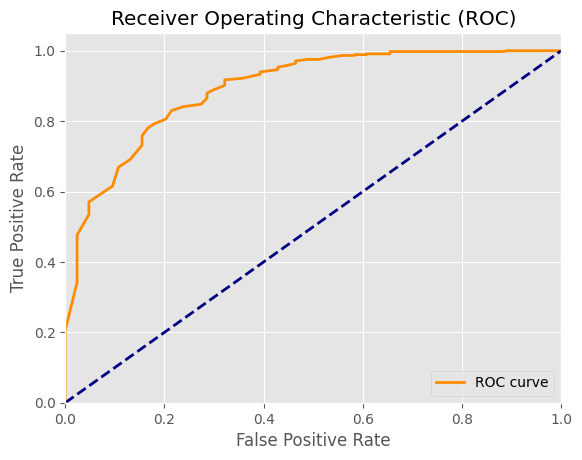

In [219]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Split the filtered dataset into features (X) and target variable (y)
X_filtered = filtered_data['tweet']
y_filtered = filtered_data['sentiment']

# Split the filtered dataset into training, validation, and testing sets
# 70% training, 15% validation, 15% testing
X_train_filtered, X_temp_filtered, y_train_filtered, y_temp_filtered = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)
X_val_filtered, X_test_filtered, y_val_filtered, y_test_filtered = train_test_split(X_temp_filtered, y_temp_filtered, test_size=0.5, random_state=42)

# Convert the target variable to binary format
y_val_binary = y_val_filtered

# Initialize CountVectorizer
count_vectorizer_filtered = CountVectorizer()

# Fit and transform the training data
X_train_bow_filtered = count_vectorizer_filtered.fit_transform(X_train_filtered)
X_val_bow_filtered = count_vectorizer_filtered.transform(X_val_filtered)
X_test_bow_filtered = count_vectorizer_filtered.transform(X_test_filtered)

# Initialize classifiers
classifiers = {
    "SVM": SVC(probability=True),  # Set probability=True to enable predict_proba
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier()
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name}:")
    clf.fit(X_train_bow_filtered, y_train_filtered)
    y_val_pred = clf.predict(X_val_bow_filtered)

    # Calculate evaluation metrics on the validation set
    accuracy_val = accuracy_score(y_val_filtered, y_val_pred)
    precision_val = precision_score(y_val_filtered, y_val_pred, average='weighted')
    recall_val = recall_score(y_val_filtered, y_val_pred, average='weighted')
    f1_val = f1_score(y_val_filtered, y_val_pred, average='weighted')
    auc_val = roc_auc_score(y_val_binary, clf.predict_proba(X_val_bow_filtered)[:, 1])

    # Print evaluation metrics
    print("Validation Accuracy:", accuracy_val)
    print("Validation Precision:", precision_val)
    print("Validation Recall:", recall_val)
    print("Validation F1-score:", f1_val)
    print("Validation AUC:", auc_val)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_val_binary, clf.predict_proba(X_val_bow_filtered)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()


**DO NOT RUN NOTEBOOK BEYOND THIS CELL**

In [220]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

# Initialize CountVectorizer
count_vectorizer = CountVectorizer()

# Fit and transform the training data
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    print(f"\n{name}:")
    clf.fit(X_train_bow, y_train)
    y_pred = clf.predict(X_test_bow)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


AttributeError: 'list' object has no attribute 'lower'

# Data visualization

# Overall sentiment distribution

In [ ]:
 #Calculate overall sentiment distribution
sentiment_distribution = data['sentiment'].value_counts()
print("Overall Sentiment Distribution:")
print(sentiment_distribution)

Overall Sentiment Distribution:
sentiment
2    4703
1    2968
0     569
Name: count, dtype: int64


This is the general overview of sentiment trends

# Most mentioned brand or product

In [ ]:
#Identify most mentioned brands/products
most_mentioned = data['product'].value_counts().head(10)
print("\nTop 10 Mentioned Brands/Products:")
print(most_mentioned)


Top 10 Mentioned Brands/Products:
product
Apple                              3762
Google                             2284
iPad                                942
iPad or iPhone App                  470
iPhone                              296
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: count, dtype: int64


By examining the top 10 most mentioned brands or products, businesses can identify which ones are receiving the most attention or discussion on social media platforms.

# Sentiment distribution for each brand or product

In [ ]:
# Sentiment distribution for each brand/product
brand_sentiment = data.groupby(['emotion_in_tweet_is_directed_at', 'is_there_an_emotion_directed_at_a_brand_or_product']).size().unstack(fill_value=0)
brand_sentiment.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Sentiment Distribution for Brands/Products")
plt.xlabel("Brand/Product")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

The plot provides a visual representation of the sentiment distribution across different brands or products to allow us grasp sentiment trends across the brands or products.

In [ ]:
#loading dataset
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='latin1')
df.head()

In [ ]:
df['emotion_in_tweet_is_directed_at'].value_counts()

In [ ]:
apple_keywords = ['apple', 'iphone', 'ipad', 'mac', 'ios','itunes']
google_keywords = ['google', 'android', 'pixel', 'chromebook','android','samsung']

# Function to check if a tweet contains keywords related to Apple or Google
def check_product(tweet):
    if isinstance(tweet, str):
        tweet_lower = tweet.lower()
        if any(keyword in tweet_lower for keyword in apple_keywords):
            return 'Apple'
        elif any(keyword in tweet_lower for keyword in google_keywords):
            return 'Google'
    return None

null_rows = df[df['emotion_in_tweet_is_directed_at'].isnull()]
null_rows['emotion_in_tweet_is_directed_at'] = null_rows['tweet_text'].apply(check_product)
df.update(null_rows)
df['emotion_in_tweet_is_directed_at'].isnull().sum()

In [ ]:
# Successfully renamed the column for our convenience.
df.rename(columns={'emotion_in_tweet_is_directed_at':'emotion_towards','is_there_an_emotion_directed_at_a_brand_or_product':'emotion_reaction'},inplace=True)

In [ ]:
df.head()

In [ ]:
#explore the data
df.info()

In [ ]:
df.isnull().sum()  # check missing values

tweet_text: There is 1 missing value in the "tweet_text" column.
emotion_towards: There are 5802 missing values in the "emotion_towards" column.
emotion_reaction: There are no missing values (0) in the "emotion_reaction" column.

In [ ]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)

In [ ]:
# filling the null values
df.dropna(inplace=True)

In [ ]:
# check if there is any missing values
df.isnull().sum()

In [ ]:
# Sort the DataFrame by the count of 'emotion_towards' in ascending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(20, 15))
ax = sns.countplot(x='emotion_towards', data=df, order=sorted_df['emotion_towards'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

In [ ]:
# Sort the DataFrame by the count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')
plt.show()

In [ ]:
#  The count of 'emotion_reaction' in descending order
sorted_df = df['emotion_reaction'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(15, 8))
ax = sns.countplot(x='emotion_reaction', data=df, order=sorted_df['emotion_reaction'], color='skyblue')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

In [ ]:
# Sort the DataFrame by the count of 'emotion_towards' in descending order
sorted_df = df['emotion_towards'].value_counts().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
plt.figure(figsize=(25, 20))
g = sns.FacetGrid(df, col="emotion_towards", col_order=sorted_df['emotion_towards'])
g.map(sns.countplot, "emotion_reaction", order=df['emotion_reaction'].value_counts().index, color='skyblue')
plt.show()

In [ ]:
df.describe()

In [ ]:
no_emotion_tweets = df[df['emotion_reaction'] == 'emotion_towards']['tweet_text']
no_emotion_tweets.count()

In [ ]:
# Get unique emotions
unique_emotions = df['emotion_reaction'].unique()
unique_emotions

In [ ]:
# Get counts of each emotion
emotion_counts = df['emotion_reaction'].value_counts()
# Sort emotions from highest to lowest
sorted_emotions = emotion_counts.sort_values(ascending=False)
sorted_emotions

In [ ]:
df.columns

In [ ]:
unique_products = df['emotion_towards'].unique()
print("Unique products mentioned:")
print(unique_products)

In [ ]:
product_counts = df['emotion_towards'].value_counts()
print("\nProduct counts:")
print(product_counts)

In [ ]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
print("\nRelevant tweets mentioning iPad:")
print(ipad_tweets.head())

In [ ]:
ipad_tweets = df[df['emotion_towards'] == 'iPad']['tweet_text']
ipad_tweets

The dataframe has 9093 rows and 3 columns.
All the data is of the object type which normally represents text or categorical data

The columns are named:
tweet_text
    -contains 9092 non-null entries of text data (ie tweets)
emotion_in_tweet_is_directed_at
    - Represents the emotion attached to a specific brand or product (e.g., “iPad”).
    - There are 3291 non-null entries.
    - The most frequent value is “iPad” (appears 946 times)
is_there_an_emotion_directed_at_a_brand_or_product
    -Indicates whether there is an emotion directed at a brand or product.
    -Four possible values:
        “Positive emotion”, “Negative emotion”,“No emotion toward brand or product” (appears 5389 times),“I can’t tell”
        


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_text(text):

    text = text.lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text into words
    words = word_tokenize(text)

    # Remove stopwords and numbers
    stop_words = set(stopwords.words('english'))
    clean_words = [word for word in words if word not in stop_words and not word.isdigit()]

    # Join the cleaned words back into a single string
    cleaned_text = ' '.join(clean_words)

    return cleaned_text


In [ ]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')
import string
stopwords_list += string.punctuation
st = nltk.PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [st.stem(word) for word in stemmed_content if word not in stopwords_list]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
df['stemmed_tweets'] = df['tweet_text'].apply(stemming)
df['stemmed_tweets'].head()



In [ ]:
df['emotion_reaction'].value_counts()

Lets drop 'I cant tell'

In [ ]:
# Create a boolean mask to identify rows where the 'emotion' column contains 'I can't tell'
mask = df['emotion_reaction'] != "I can't tell"

# Apply the mask to filter out rows where the 'emotion' column contains 'I can't tell'
df_filtered = df[mask]

df_filtered.reset_index(drop=True, inplace=True)


In [ ]:
df_filtered['emotion_reaction'].value_counts()

we remove no emotion too

In [ ]:
df_filtered['emotion_reaction'] = df_filtered['emotion_reaction'].replace({'Positive emotion':1,'Negative emotion':0})
df_filtered['emotion_reaction'].value_counts()

Split Data to X and Y for modelling

In [ ]:

# List of Apple products and apps
apple_products_and_apps = ['Apple', 'iPad', 'iPhone', 'iPad or iPhone App', 'Other Apple product or service']

# List of Google products and apps
google_products_and_apps = ['Google', 'Android', 'Android App', 'Other Google product or service']

# Combine both lists
products_and_apps_to_include = apple_products_and_apps + google_products_and_apps

# Create a regular expression pattern from the combined list
pattern = '|'.join(products_and_apps_to_include)

# Filter rows where the 'emotion_towards' column contains the specified products and apps
df_filtered = df_filtered[df_filtered['emotion_towards'].str.contains(pattern)]

# Display the filtered DataFrame
df_filtered.head()


Clean text

In [ ]:
df_filtered['stemmed_tweets'] = df_filtered['stemmed_tweets'].apply(clean_text)
df_filtered.head()

In [ ]:
null_rows = df_filtered.copy()

In [ ]:
# Create a boolean mask to identify rows where the 'emotion' column contains 'I can't tell'
mask = df_filtered['emotion_reaction'] != "No emotion toward brand or product"

df_filtered.drop(df_filtered[~mask].index, inplace=True)

df_filtered['emotion_reaction'].value_counts()

In [ ]:
X = df['stemmed_tweets'].values
Y = df['emotion_reaction'].values
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=42)

In [ ]:
print(X_test)

Convert to numerical data

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [ ]:
print(X_train)

Training the LogReg model

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train,y_train)


In [ ]:
df_filtered['emotion_reaction'].value_counts()

In [ ]:
y_pred = model.predict(X_train)
train_data_accuracy = accuracy_score(y_train,y_pred)
y_pred_test = model.predict(X_test)
test_data_accuracy = accuracy_score(y_test,y_pred_test)
print(f'Test Data Accuracy Score: {test_data_accuracy * 100} % \n Train Data Accuracy Score: {train_data_accuracy*100} %')

In [ ]:
# Example tweet text
tweet_text = ".@wesley83 I have a 3G iPhone. After 3 hrs twe..."

# Print original tweet text
print("Original Text:", tweet_text)

# Clean the tweet text
cleaned_text = clean_text(tweet_text)

# Print cleaned tweet text
print("Cleaned Text:", cleaned_text)

In [ ]:
null_rows['emotion_reaction'] = null_rows['emotion_reaction'].replace({'No emotion toward brand or product':2})
null_rows['emotion_reaction'].value_counts()
logreg_multi = LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)
X_m = null_rows['stemmed_tweets'].values
Y_m = null_rows['emotion_reaction'].values
x_ttrain,x_ttest,y_ttrain,y_ttest = train_test_split(X_m,Y_m,test_size=0.2,stratify=Y_m)
x_ttrain = vectorizer.fit_transform(x_ttrain)
x_ttest = vectorizer.transform(x_ttest)
logreg_multi.fit(x_ttrain,y_ttrain)
y_mtrain_pred = logreg_multi.predict(x_ttrain)
y_mtest_pred = logreg_multi.predict(x_ttest)
multi_accuracy_score_train = accuracy_score(y_ttrain,y_mtrain_pred)
multi_accuracy_score_test = accuracy_score(y_ttest,y_mtest_pred)
print(f'Multi Train Accuracy: {multi_accuracy_score_train*100} % \nMulti Test Accuracy: {multi_accuracy_score_test*100} %')
# null_rows_X = null_rows['stemmed_tweets']
# no_reaction_pred = model.predict(null_rows_X)
